# Kaggle Titanic's Competition

*This notebook is aimed at providing detailed steps taken in achieving __76%__ accuracy in the competition*

Details of the competition including the data dictionary, the test and train datasets can be found [here](https://www.kaggle.com/c/titanic/data)

## Kaggle Workflow

The image below explains the steps that will be taken 
- Data Exploration
- Feature Engineering
- Feature Selection
- Model Selection/Tuning
- Finally, submit to Kaggle

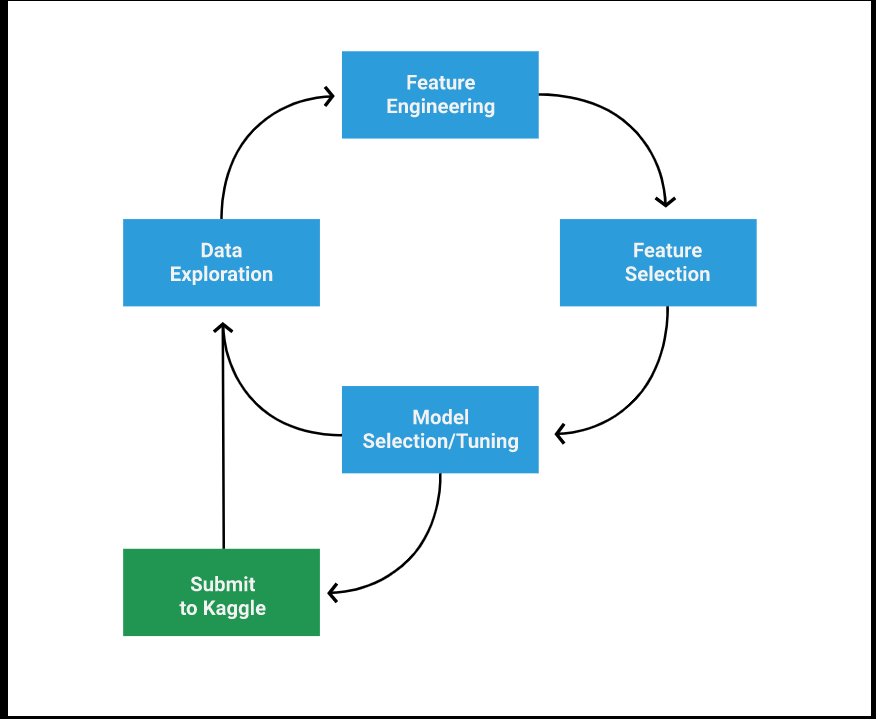

In [1]:
#import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
#Read in the data set
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

## Data Exploration

In [3]:
#Preview the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Data Dictionary

*For easy access, the data dictionary is provided below.*

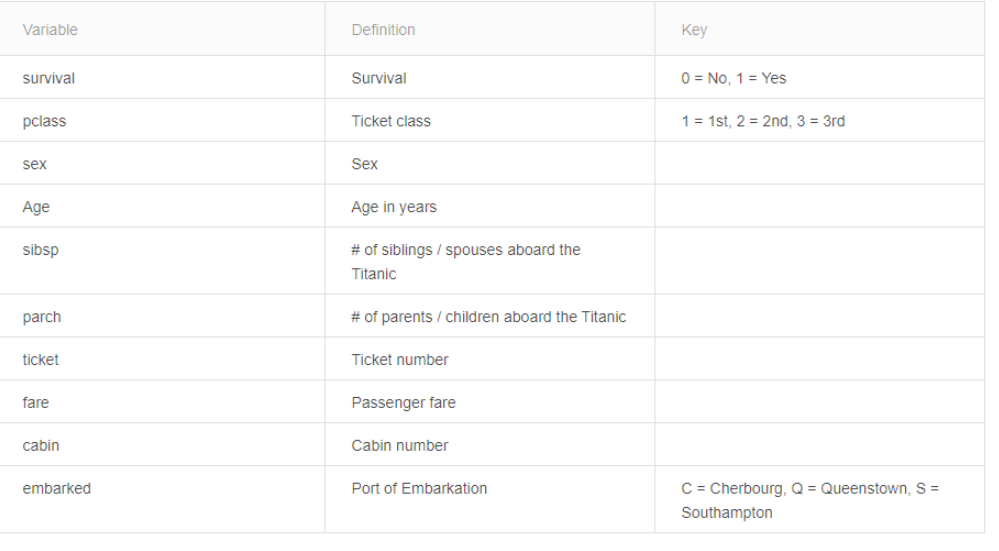

### Clean Column Headers

In [5]:
def lower_and_strip(df):
    """Lowers the capitalization of the column names and strips off whitespace
    
    Args: Dataframe
    
    Returns: Dataframe
        
    """
    cols = df.columns
    cols = cols.str.strip().str.lower()
    df.columns = cols
    return df

In [6]:
train = lower_and_strip(train)
holdout = lower_and_strip(holdout)
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

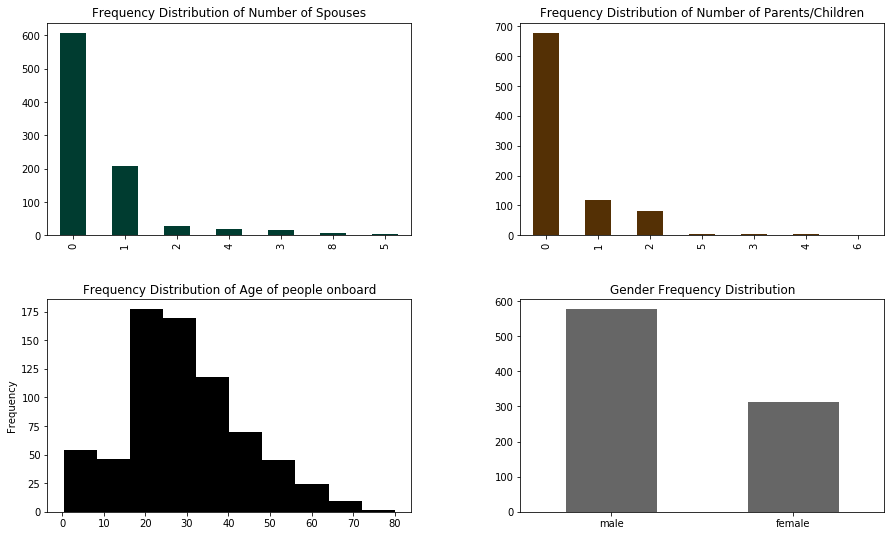

In [7]:
#Visualize some columns to see frequency distribution

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 9))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.3, wspace=.3)

train['sibsp'].value_counts().plot(kind = 'bar',
                                  ax = ax1,
                                  title = 'Frequency Distribution of Number of Spouses',
                                  colormap = plt.cm.BrBG_r)

train['parch'].value_counts().plot(kind = 'bar',
                                  ax = ax2,
                                  title = 'Frequency Distribution of Number of Parents/Children',
                                  colormap = plt.cm.BrBG)

train['age'].plot(kind = 'hist',
                                 ax = ax3,
                                 title = 'Frequency Distribution of Age of people onboard',
                                 colormap = plt.cm.afmhot)

train['sex'].value_counts().plot(kind = 'bar',
                                  ax = ax4,
                                  title = 'Gender Frequency Distribution',
                                  colormap = plt.cm.Accent_r,
                                 rot = 0)

*__Insight:__*

- There are more male than female 
- Most people are adults between the ages of 20 and 40

## Feature Engineering

In [8]:
#Diving into the age column
train['age'].value_counts(dropna = False)

NaN      177
24.00     30
22.00     27
18.00     26
28.00     25
        ... 
36.50      1
55.50      1
66.00      1
23.50      1
0.42       1
Name: age, Length: 89, dtype: int64

In [9]:
#Converting the age column into a categorical variable
train["age"] = train["age"].fillna(-0.5)
holdout["age"] = holdout["age"].fillna(-0.5)

def process_age(df):
    """Convert the age column into a categorical variable
    
    Args: DataFrame
    
    Returns: DataFrame
    """
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["age_categories"] = pd.cut(df["age"],cut_points,labels=label_names)
    return df

In [10]:
train = process_age(train)
holdout = process_age(holdout)

In [11]:
train['fare'].value_counts(dropna = False).sort_index(ascending = False)

512.3292     3
263.0000     4
262.3750     2
247.5208     2
227.5250     4
            ..
6.4375       1
6.2375       1
5.0000       1
4.0125       1
0.0000      15
Name: fare, Length: 248, dtype: int64

In [12]:
#Convert the fare column to a categorical variable

def process_fare(df):
    '''Converts the fare column into a categorical variable so dummies can be created from it
    
    Args: dataframe
    
    Returns: DataFrame
        '''
    cut_points = [0,12,50,100,1000]
    label_names = ['0-12','12-50','50-100','100+']
    df['fare_categories'] = pd.cut(df['fare'], cut_points, labels=label_names)
    return df

In [13]:
train = process_fare(train)
holdout = process_fare(holdout)

In [14]:
train['embarked'].value_counts(dropna = False)

S      644
C      168
Q       77
NaN      2
Name: embarked, dtype: int64

In [15]:
holdout['embarked'].value_counts(dropna = False)

S    270
C    102
Q     46
Name: embarked, dtype: int64

In [16]:
#Fill the na values in the train dataframe with 'S', which represents the value with the highest frequency
train['embarked'] = train['embarked'].fillna('S')
train['embarked'].value_counts(dropna = False)

S    646
C    168
Q     77
Name: embarked, dtype: int64

In [17]:
train['cabin'].value_counts(dropna = False)

NaN            687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
              ... 
C70              1
D37              1
A14              1
D46              1
C47              1
Name: cabin, Length: 148, dtype: int64

In [18]:
train['cabin'].str[0]

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: cabin, Length: 891, dtype: object

__The cabin type column contains a lot of nan values. From previewing the clumn, we see that the first leter represents the cabin type, so we will use this information to create a new column for those rows that have cabin types, while we return 'unknown' for those that do not have__

In [19]:
#Process the Cabin column into pre-defined 'bins
def process_cabin(df):
    """Convert the cabin column into cabin type 

    Args: DataFrame
    
    Returns: Dataframe
    """
    df["cabin_type"] = df["cabin"].str[0]
    df["cabin_type"] = df["cabin_type"].fillna("Unknown")
    return df

In [20]:
train = process_cabin(train)
holdout = process_cabin(train)

holdout = holdout.drop('cabin', axis = 1)
train = train.drop('cabin',axis=1)

In [21]:
def process_titles(df):
    """Extract and categorize the title from the name column
    
    Args: DataFrame
    
    Returns: Dataframe
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["name"].str.extract(' ([A-Za-z]+)\.', expand=False)
    df["title"] = extracted_titles.map(titles)
    return df

In [22]:
train = process_titles(train)
holdout = process_titles(holdout)

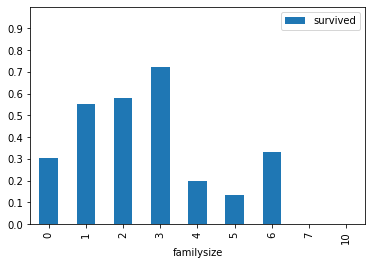

In [23]:
#create a new dataframe
explore_cols = ["sibsp","parch","survived"]
explore = train[explore_cols].copy()
explore_holdout = holdout[explore_cols].copy()

#Create a new column that sums the sibsp & parch columns
explore['familysize'] = explore[["sibsp","parch"]].sum(axis=1)
explore_holdout['familysize'] = explore_holdout[["sibsp","parch"]].sum(axis=1)

#Pivot table based on the mean of survived people
pivot_train = explore.pivot_table(index='familysize',values="survived")
pivot_holdout = explore_holdout.pivot_table(index='familysize',values="survived")

pivot_train.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [24]:
def is_alone(df):
    """Creates a new column, isalone, checking if the family size is greater than zero
        Returns 1 if yes, and 0 if no
        
    Args: Dataframe
        
    Returns: Dataframe
    """
    try:
        df['isalone'] = np.where(explore['familysize'] > 0, 0, 1)
    except:
        df['isalone'] = np.where(explore_holdout['familysize'] > 0, 0, 1)
    return df

In [25]:
train = is_alone(train)
holdout = is_alone(holdout)

In [26]:
train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,age_categories,fare_categories,cabin_type,title,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,0-12,Unknown,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,50-100,C,Mrs,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,0-12,Unknown,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,50-100,C,Mrs,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,0-12,Unknown,Mr,1


In [27]:
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Args: Dataframe
          column_name ('string')
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [28]:
for feature in ['age_categories','pclass','sex', 'cabin_type', 'title']:
    train = create_dummies(train, feature)
    holdout = create_dummies(holdout, feature)

In [29]:
train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,...,cabin_type_F,cabin_type_G,cabin_type_T,cabin_type_Unknown,title_Master,title_Miss,title_Mr,title_Mrs,title_Officer,title_Royalty
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,1,0,0,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,1,0,1,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,1,0,0,1,0,0,0


In [30]:
#Lower and strip again because of the newly created columns
train = lower_and_strip(train)
holdout = lower_and_strip(holdout)
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'embarked', 'age_categories',
       'fare_categories', 'cabin_type', 'title', 'isalone',
       'age_categories_missing', 'age_categories_infant',
       'age_categories_child', 'age_categories_teenager',
       'age_categories_young adult', 'age_categories_adult',
       'age_categories_senior', 'pclass_1', 'pclass_2', 'pclass_3',
       'sex_female', 'sex_male', 'cabin_type_a', 'cabin_type_b',
       'cabin_type_c', 'cabin_type_d', 'cabin_type_e', 'cabin_type_f',
       'cabin_type_g', 'cabin_type_t', 'cabin_type_unknown', 'title_master',
       'title_miss', 'title_mr', 'title_mrs', 'title_officer',
       'title_royalty'],
      dtype='object')

## Feature Selection

In [31]:
def select_features(df):
    """Selects and returns the best features
    
    """
    #drop na values
    df = df.dropna()
    
    #Exclude object and category types
    df = df.select_dtypes(exclude = ['object','category'])
    
    #Partition the data for training, hence the survived column needs to be dropped
    all_x = df.drop(['passengerid', 'survived'], axis = 1)
    
    #The column where the solution can be found
    all_y = df['survived']
    
    #Initialize the random_state classifier
    rf = RandomForestClassifier(random_state=1, n_estimators=10)
    
    #initialzie the RFECV model selector
    selector = RFECV(rf, cv =10)
    
    #Train the model
    selector.fit(all_x, all_y)
    print(all_x.columns[selector.support_])
    return all_x.columns[selector.support_]

In [32]:
best_features = select_features(train)

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'isalone',
       'age_categories_missing', 'age_categories_infant',
       'age_categories_young adult', 'pclass_3', 'sex_female', 'sex_male',
       'cabin_type_e', 'cabin_type_unknown', 'title_miss', 'title_mr'],
      dtype='object')


## Model Selection

In [33]:
def select_model(df, features):
    """Select a model based on the best hyper-parameters using grid search
    
    Args: DataFrame
    
    Returns: DataFrame
    """
    
    all_x = df[features]
    all_y = df['survived']
    list_of_dict = [
        {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
                {
                "solver": ["lbfgs", "newton-cg", "liblinear"]
                }
        },
        
        {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
                {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
                }
        },
        
        {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
                {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
                }
        },
        
    ]
    
    for value in list_of_dict:
        print(value['name'])
        grid = GridSearchCV(value['estimator'], value['hyperparameters'],cv = 10)
        grid.fit(all_x, all_y)
        value['best_score'] = grid.best_score_
        value['best_parameter'] = grid.best_params_
        value['best_estimator'] = grid.best_estimator_
        #print(value['best_score'], value['best_parameter'], '\n\n')
        
    return list_of_dict

In [34]:
dict_with_models = select_model(train, best_features)

LogisticRegression


C:\Users\Uchenna.Alozie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Uchenna.Alozie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Uchenna.Alozie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Uchenna.Alozie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Uchenna.Alozie\AppData\Local\Continuum\anaconda3\li

KNeighborsClassifier


C:\Users\Uchenna.Alozie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier


In [35]:
dict_with_models[0]['best_estimator']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
def save_submission_file(trained_model, cols):
    prediction = trained_model.predict(holdout[cols])
    submission = pd.DataFrame({'PassengerId': holdout['passengerid'],
                          'Survived': prediction})
    submission.to_csv('submission_2.csv', index = False)

## Kaggle Submission

__*First submission*__

In [37]:
save_submission_file(dict_with_models[0]['best_estimator'], best_features)
dict_with_models[0]['best_estimator']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

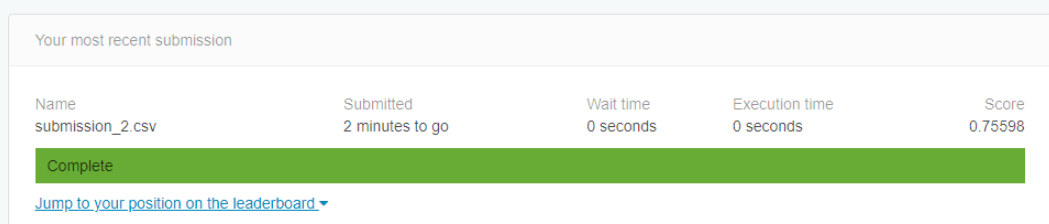

__*Second Submission*__

In [38]:
save_submission_file(dict_with_models[1]['best_estimator'], best_features)
dict_with_models[1]['best_estimator']

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                     weights='uniform')

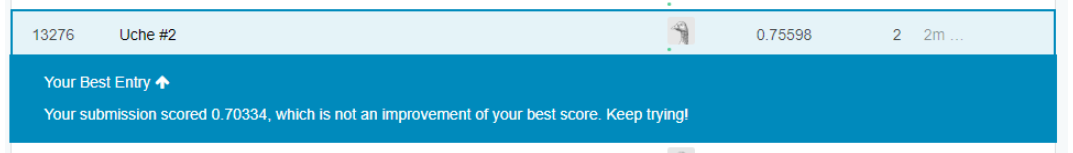

*The second model actually performed worse than the first model*

__*Third Submission*__

In [39]:
save_submission_file(dict_with_models[2]['best_estimator'], best_features)
dict_with_models[2]['best_estimator']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

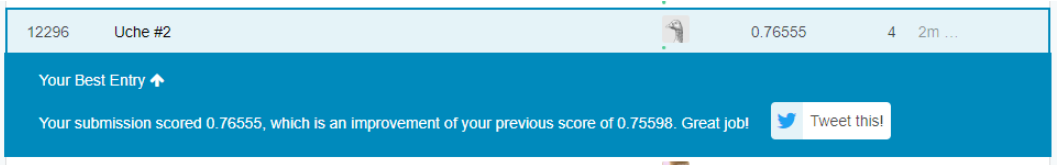

__*The Best of Them so far*__

# Conclusion

The model with the highest accuracy turned out to be the Random Forest Classifier with a n_estimators = 9 a striking value among the hyper-parameters.
We could assume that the random classifier perfomed best because the best set of features was obtained from the RFECV feature selection was instantiated using the random forest classifier

__Further Steps__
- Instantiate the RFECV using logistic Regression
- Perform more feature engineering

# Thank You